<center><b>Ecole Polytechnique, Cycle Ingénieur (2A)<b></center>
<center>APM_41M01_EP - Problem solving en mathématiques appliquées</center>
<center>Enseignants : Ludovic Goudenège <a href="mailto:ludovic.goudenege@polytechnique.edu">(mail)</a>
    Teddy Pichard	<a href="mailto:teddy.pichard@polytechnique.edu">(mail)</a>
        </center>



# Résolution de k-SAT par Monte-Carlo

In [74]:
# # css style
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("./style/custom2.css").read()
#     return HTML(styles)
# css_styling()

In [75]:
# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing
import random
%matplotlib inline

## Table des matières

- [k-SAT et exploration aléatoire](#kSAT)
  - k-SAT : Définition et Préliminaires
  - [Résolution de $2$-SAT avec <i>WalkSat</i>](#WalkSat)
  - [<i>WalkSat</i> : choix du paramètre $T$](#ChoixT)  
- [Matrices de transitions : Calcul de $\mathbb{P}(\tau < 2n^2)$](#Annexe)
- [Application : Transition de phase pour $2$-SAT](#Transition)


Pour un problème sur un espace fini, les méthodes <i>Monte-Carlo Markov Chain</i> (MCMC) consistent à parcourir l'ensemble des solutions possibles de façon aléatoire mais astucieuse. On cherche ainsi à déterminer la solution optimale, ou proche de l'optimal.

L'objectif de ce TP est d'illustrer la puissance de la stratégie MCMC sur un problème particulier : le problème $k$-SAT en informatique théorique. C'est aussi un prétexte pour utiliser les matrices de transitions.

Une référence pour ce TP est :<br>
[1] MITZENMACHER, Michael et UPFAL, Eli. Probability and computing: Randomization and probabilistic techniques in algorithms and data analysis. Cambridge university press, 2017. (pages 156-159)


<a id="kSAT"></a>
# Le problème k-SAT

Le problème SAT en informatique théorique (aussi appelé problème de satisfaisabilité booléenne) est le problème de décision qui, étant donné une formule de logique booléenne, détermine s'il existe une assignation des variables qui rend la formule vraie.

Nous allons définir tous les termes et restreindre le contexte.

Ici on va spécifiquement s'intéresser au problème $k$-SAT. Soit $k$ fixé (dans ce TP on va prendre uniquement $k\in \{2,3\})$ et étant données $n$ variables booléennes $x_1,x_2,\dots,x_n \in \{\text{Vrai},\text{Faux}\}$, on considère les formules booléennes de la forme ($\vee$ signifie 'ou' et $\wedge$ signifie 'et')<br><br>
$$
(z_{1,1} \vee z_{1,2} \vee \dots \vee z_{1,k}) \wedge \dots \wedge (z_{M,1} \vee z_{M,2} \vee \dots \vee z_{M,k})
$$
<br>
où
* $M$ est un entier quelconque
* pour chaque $1\leq m\leq M$ et chaque $i\leq k$ on a
<br>
$$
z_{m,i}\in \big\{x_1,x_2,\dots,x_n,\overline{x_1},\overline{x_2},\dots,\overline{x_n}\big\}.
$$

(La notation $\overline{x}$ désigne la négation de $x$.)
Chaque terme $(z_{m,1} \vee z_{m,2} \vee \dots \vee z_{m,k})$ est appelée une clause.

Par exemple pour $2$-SAT avec $n=5$ variables, une formule à $M=3$ clauses est donnée par
<br><br>
$$
F=(x_1 \vee \overline{x_5}) \wedge (x_2 \vee x_3)  \wedge (\overline{x_1} \vee x_2)
$$
<br>
Une <i>affectation</i> est une fonction $x_1,x_2,\dots,x_n \in \{\text{Vrai},\text{Faux}\}$. S'il existe une affectation qui rende $F$ vraie on dit que $F$ est **satisfiable**.

Dans le cas de l'exemple ci-dessus, une <i>affectation</i> des variables qui rende $F$ vraie est :
$$
x_1=\text{Faux},\ x_2=\text{Vrai},\ x_3=\text{Faux},\ x_4=\text{Faux},\ x_5=\text{Faux}.
$$

Spécifiquement, le problème $k$-SAT est de trouver un algorithme qui, étant donnée une formule $F$, trouve une affectation des variables qui rende $F$ vraie (ou qui retourne `impossible` si une telle affectation n'existe pas). Le problème 2-SAT est polynomial alors que 3-SAT est NP-complet (voir par exemple : S.Perifel. Complexité algorithmique. Ellipses (2014))

<div markdown=1 class="DoIt">

Ecrire des fonctions `ClauseVraie(Clause,Affectation,nb_variables)` et `FonctionVraie(Formule,Affectation,nb_variables)` qui prennent en entrée des clauses ou formules et une affectation, et calcule si la clause/formule est vraie ou pas.

On pourra représenter les formules sous la forme de liste :
```
Formule = [Clause1,Clause2,...,ClauseM]
```
où chaque `Clause` est de la forme
```
Clause = [z_1,...,z_k]
```
et chaque $z_i$ est un booléen. Dans les clauses on peut numéroter les booléens de $0$ à $n-1$ pour $x_1, \dots,x_n$ et de $n$ à $2n-1$ pour leurs négations. Pour l'exemple plus haut :
```
F=[[0,9],[1,2],[5,1]]
```
car (par exemple) $\overline {x_5}$ est codé par $9$. L'affectation donnée en exemple est alors
```
[0,1,0,0,0]
```

In [76]:
####################################
# ---- tester une clause
####################################

def ClauseVraie(Clause,Affectation,nb_variables):
    return any([(i < nb_variables and Affectation[i]) or (i >=  nb_variables and not Affectation[i - nb_variables]) for i in Clause])

# Test
n=2
Clause1=[0,1]  # x_1 ou x_2
Clause2=[2,1]  # non(x_1) ou x_2
Clause3=[2,3]  # non(x_1) ou non(x_2)

Affectation1=[1,0] # x_1 vraie et x_2 fausse

print(ClauseVraie(Clause1,Affectation1,n)) # doit renvoyer True
print(ClauseVraie(Clause2,Affectation1,n)) # doit renvoyer False
print(ClauseVraie(Clause3,Affectation1,n)) # doit renvoyer True

True
False
True


In [77]:
####################################
# ---- tester une formule
####################################

def FormuleVraie(Formule,Affectation,nb_variables):
    return all([ClauseVraie(clause, Affectation, nb_variables) for clause in Formule])

# test
Formule1=[Clause1,Clause2]
Formule2=[Clause1,Clause3]
Formule3=[Clause2,Clause3]
print([FormuleVraie(f,Affectation1,2) for f in [Formule1,Formule2,Formule3]]) # Doit renvoyer [False, True, False]

# test
Formule=[[0,9],[1,2],[5,1]]
Affectation=[0,1,0,0,0]
print(FormuleVraie(Formule,Affectation,5)) # Doit renvoyer True

[False, True, False]
True


<a id="WalkSat"></a>
## 2-SAT : l'algorithme WalkSat

Le problème 2-SAT est polynomial, donc "simple" à résoudre. Nous allons voir qu'un algorithme probabiliste extrêmement naïf en vient (presque) à bout.<br><br>
<b>Algorithme WalkSat</b> <br>
<b>entrées :</b> Formule $F$ à $M$ clauses sur $n$ variables.<br>
<b>paramètre :</b> $T$ entier<br>
<b>sortie :</b>
* Si c'est possible, renvoyer une affectation qui rende $F$ vraie
* Sinon, renvoyer `je n'ai pas trouvé`.

1. Initialisation :
    - On tire une affectation `Affectation`$=(x_1,\dots,x_n)$ uniforme au hasard dans $\{\text{Vrai},\text{Faux}\}^n$
    - On pose Compteur $= 0$.
2. Tant que Compteur < $2Tn^2$ et formule fausse :
  * 2a) Chercher la première clause non satisfaite
  * 2b) Dans cette clause, choisir une variable $x_i$ uniformément au hasard et la changer de valeur : $x_i \leftarrow \text{non}(x_i)$.
  * 2c) Si `Affectation` rend la formule vraie, renvoyer `Affectation`
  * 2d) Compteur = Compteur $+ 1$.
3. Renvoyer `je n'ai pas trouvé`

<i>(La raison pour laquelle on écrit le nombre de boucles sous la forme $2Tn^2$ apparaîtra à la partie suivante.)</i>


<div markdown=1 class=Rmk>

**Attention** L'algorithme WalkSat n'est pas tout à fait correct. Lorsque WalkSat renvoie `je n'ai pas trouvé`, cela ne signifie pas forcément que la formule n'est pas satisfiable mais peut-être simplement que l'algorithme n'a pas cherché assez longtemps.

<div markdown=1 class="DoIt">

Ecrire une fonction `UneEtapeWalkSat(n_var,Formule,Affectation)` qui effectue une fois les opérations 2a)-2b)-2c) dans la description de l'Algorithme WalkSat.

In [78]:
def UneEtapeWalkSat(n_var,Formule,Affectation):
    for clause in Formule:
        if not ClauseVraie(clause, Affectation, n_var):
            i = random.choice(clause)
            if i >= n_var:
                i -= n_var
            Affectation[i] = not Affectation[i]
            if FormuleVraie(Formule, Affectation, n_var):
                return True, Affectation
            return False, Affectation

    return  True, Affectation

<div markdown=1 class="Answers">

<a id="ChoixT"></a>
## WalkSat : choix du paramètre $T$

Rappelons les propriétés suivantes de l'algorithme WalkSat appliqué à une formule $F$ à $n$ variables :
   - Si $F$ est fausse, l'algorithme renvoie `je n'ai pas trouvé`
   - Si $F$ est satisfiable
      * Avec une proba que l'on va noter $p(n,T,F,\mathbf{x})$ où $\mathbf{x}=(x_1,\dots,x_n)$ est l'affectation initiale, l'algorithme se trompe et renvoie `je n'ai pas trouvé`
      * Avec une proba $1-p(n,T,F,\mathbf{x})$ il renvoie une affectation correcte.
   
On note
$$
p_\star(n,T) = \max_{F\text{ satisfiable},\mathbf{x}} p(n,T,F,\mathbf{x})
$$
où $\mathbf{x}=(x_1,\dots,x_n)$ est l'affectation initiale.

Tout l'enjeu est d'avoir une bonne majoration de $p_\star(n,T)$ en fonction de $T$.

Fixons une formule $F$ satisfiable, et fixons également une affectation $(y_1,\dots,y_n)$ correcte pour $F$. Pour $t\geq 0$ on note $(x_1^t,\dots,x_n^t)$ l'affectation de WalkSat à l'instant $t$.<br>
<!--<i>(Rappelons que $(x_1^0,\dots,x_n^0)$ sont uniformes indépendants.)</i><br>-->
Soit
$$
D_t = \mathrm{card} \{ i \text{ tels que } x_i^t \neq y_i\}.
$$
Le processus $(D_t)_{t}$ est un processus aléatoire à valeurs dans $\{0,1,\dots,n\}$, lorsqu'il touche $0$ alors on a trouvé une affectation pour $F$. On introduit le temps aléatoire :

$$
\tau_D = \min\{t, (x_1^t,\dots,x_n^t)\text{ est une affectation correcte.}\}
$$

<div markdown=1 class="DoIt">

**(Théorie)**

Soit $(S_t)_{t}$ le processus défini de la façon suivante :

   - $S_0=n$
   - Si $S_t=n$, alors $S_{t+1}=n-1$
   - Si $S_t=0$ alors $S_{t+1}=0$
   - Sinon $S_t$ vaut $S_t -1$ ou $S_t + 1$ avec probabilité $1/2$, indépendamment du passé.
   
Ainsi $(S_t)$ est la marche aléatoire symétrique sur l'intervalle $[0,n]$, réfléchie en $n$ et absorbée en $0$. On note
<br>
<br>
$$
\tau_S = \min\{t, S_t=0\}.
$$
<br>
Démontrer que dans un certain sens $\tau_D$ a tendance à arriver plus tôt que $\tau_S$. Formellement, pour tout $t$,
<br><br>
$$
\mathbb{P}(\tau_D\geq t) \leq \mathbb{P}(\tau_S\geq t).
$$
<i>(Il n'est pas facile de rédiger soigneusement cette question, essayez plutôt de vous convaincre que c'est vrai!)</i>

<img src="figures/MarchesAleatoires.jpg" style="width:600px;"/>


<div markdown=1 class="Answers">



<div markdown=1 class="DoIt"> **(Théorie)**

Dans la section suivante vous allez vérifier numériquement que pour tout $n\geq 10$ alors
$$
\mathbb{P}(\tau_S\leq 2n^2) \geq  0.89.
$$
Grâce aux questions précédentes cela implique que
$$
\mathbb{P}(\tau_D\leq 2n^2) \geq  0.89.\qquad (\star)
$$

En utilisant $(\star)$, déterminer $T$ pour que pour toute formule satisfiable $F$ alors
$$
\mathbb{P}(\mathrm{WalkSat}\text{ trouve une affectation pour }F)\geq 1-\varepsilon.
$$
**Application numérique.**
Trouver $T$ pour que
$$
\mathbb{P}(\mathrm{WalkSat}\text{ trouve une affectation pour }F)\geq 99,99\%
$$

<div markdown=1 class="Answers">

In [79]:
# Application numérique
def build_transitions(n):
    transitions = np.zeros((n+1, n+1))
    for i in range(1, n):
        transitions[i][i-1] = 0.5
        transitions[i][i+1] = 0.5
    transitions[0][0] = 1.0
    transitions[n][n-1] = 1.0
    return transitions

def compute_T(n, eps):
    transitions = build_transitions(n)
    v = np.zeros(n+1)
    v[n] = 1.0

    T = 1
    while True:
        steps = 2 * n**2 * T
        v_temp = v.copy()
        for _ in range(steps):
            v_temp = v_temp @ transitions
        if v_temp[0] >= 1 - eps:
            return T
        T += 1

In [80]:
n = 10
eps = 1e-2
T = compute_T(n, eps)
print(f"T minimal pour n={n} et eps={eps} : {T}")

T minimal pour n=10 et eps=0.01 : 2


<div markdown=1 class="DoIt">

**(Théorie)** Mais au fait, pourquoi la stratégie WalkSat ne marche pas pour $3$-SAT?

WalkSat ne fonctionne pas bien pour le 3-SAT car ce problème est NP-complet, ce qui signifie que l’espace des solutions est beaucoup plus complexe et piégeux que pour le 2-SAT. Le modèle probabiliste utilisé dans le notebook pour garantir le succès de WalkSat sur 2-SAT ne s’applique plus, car il repose sur une structure trop simple pour capturer la difficulté du 3-SAT.

<a id="Annexe"></a>
# Calcul de $\mathbb{P}(\tau_S\leq \lambda  𝑛^2)$ (matrices de transition)

Rappelons que $(S_t)$ est la marche aléatoire symétrique partant de $n$, réfléchie en $n$ et absorbée en $0$. On note $\tau_S = \min\{t, S_t=0\}$.

Pour déterminer $T$ nous avons eu besoin d'estimer numériquement la probabilité $\mathbb{P}(\tau_S\leq 2 𝑛^2)$. Nous allons pour cela utiliser une matrice de transition. Pour $t\geq 0$ et $0\leq i,j\leq n$ on note
<br><br>
$$
p_{i,j}^{(t)}=\mathbb{P}\left(\text{ en partant de $i$, }S_t=j\right).
$$


<div markdown=1 class="DoIt">

1. Soit $0\leq i\leq n$, $1\leq j\leq n-1$ et $t\geq 0$. Justifier que
$$
p^{(t)}_{i,j}=\tfrac{1}{2}p^{(t-1)}_{i,j-1}+\tfrac{1}{2}p^{(t-1)}_{i,j+1}.
$$
2. Réfléchir rapidement au cas $j=0$ ou $j=n$ dans l'équation suivante et en déduire qu'il existe une matrice $Q_n$ de taille $(n+1)\times (n+1)$telle que pour tous $t,i,j$,
$$
p^{(t)}_{i,j}= (Q_n^t)_{i,j}.
$$
Cette matrice $Q_n$ est appellée matrice de transition du processus $(S_t)$.
3. Ecrire $\mathbb{P}(\tau_S\leq t)$ en fonction de $Q_n$. En déduire un code python qui calcule $\mathbb{P}(\tau_S\leq 2 n^2)$ de façon exacte et vérifier sur un graphique que cette probabilité semble converger lorsque $n\to +\infty$.

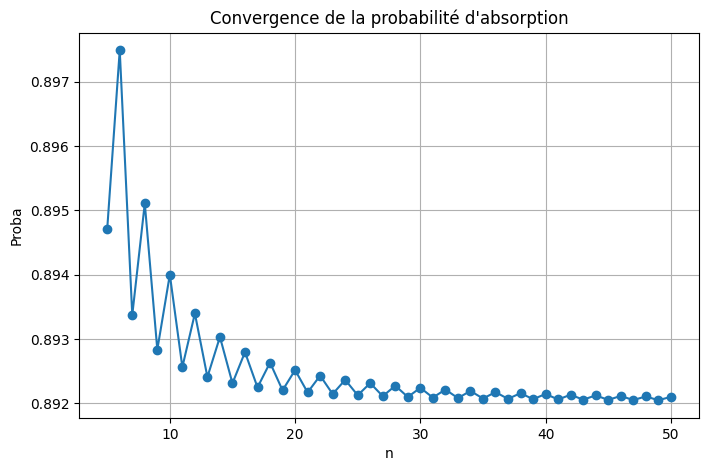

In [81]:
def absorpt_prob(n, steps):
    transitions = build_transitions(n)
    v = np.zeros(n+1)
    v[n] = 1.0
    for _ in range(steps):
        v = v @ transitions
    return v[0]

# Tracé
ns = np.arange(5, 51)
probs = np.array([absorpt_prob(n, 2 * n**2) for n in ns])

plt.figure(figsize=(8, 5))
plt.plot(ns, probs, marker='o')
plt.xlabel("n")
plt.ylabel("Proba")
plt.title("Convergence de la probabilité d'absorption")
plt.grid(True)
plt.show()

<div markdown=1 class="Answers">

<a id="Transition"></a>
# Application : Illustration de la transition de phase

Le problème $2$-SAT aléatoire (lorsque les formules sont tirées aléatoirement et uniformément) présente un phénomène de <i>transition de phase</i>. Pour être plus formel nous introduisons quelques notations.<br><br>
Il y a $\binom{2n}{2}^M$ formules différentes avec $M$ clauses et $n$ variables (on considère que l'ordre des clauses compte, mais pas l'ordre des variables dans une clause). Notons
$$
p(n,M)
$$
la probabilité qu'une formule aléatoire uniforme parmi les $\binom{2n}{2}^M$ formules différentes soit vraie.
On a bien sûr $p(n,M)$ qui est décroissante en $M$ (plus il y a de clauses plus c'est difficile d'être vraie).

Pour $c>0$ on a, lorsque $n\to +\infty$ :
$$
p(n,c\times n)\to
\begin{cases}
1 &\text{ si }c<1\\
0 &\text{ si }c>1
\end{cases}
$$

Référence : GENT, Ian P. et WALSH, Toby. The SAT phase transition. In : <i>ECAI</i>, 1994. p. 105-109.

<div markdown=1 class="DoIt">

1. Ecrire une fonction `TirerClause(k,nb_variables)` qui prend en entrées deux entiers $k,n$ et renvoie une clause de $k$-SAT à $n$ variables, uniformément au hasard.
2. Ecrire une fonction `TirerFormule(k,nb_variables,M)` qui renvoie une formule de $M$ clauses de $k$-SAT à $n$ variables, uniformément au hasard.

<br>
<i>(On considère qu'il y a $\binom{2n}{2}^M$ formules différentes avec $M$ clauses et $n$ variables : l'ordre des clauses compte, mais pas l'ordre des variables dans une clause.)</i>

In [82]:
def TirerClause(k,nb_variables):
    return np.random.choice(2*nb_variables, k)

def TirerFormule(k,nb_variables,M):
    return np.array([TirerClause(k, nb_variables) for _ in range(M)])

TirerFormule(3, 5, 4)

array([[8, 7, 6],
       [4, 0, 3],
       [0, 6, 6],
       [2, 6, 0]])

<div markdown=1 class="Answers">

<div markdown=1 class="DoIt">

1. Ecrire un solveur WalkSat qui utilise le paramètre $T$ choisi à l'exercice précédent.
2. En utilisant des simulations et le solveur WalkSat, illustrer la transition de phase en $c=1$.

In [83]:
def solv_WalkSat(F, T, n):
    affectation = np.random.choice(2, n)
    counter = 0

    while counter < 2*T*n**2:
        # print("*", affectation)
        boolean, affectation = UneEtapeWalkSat(n, F, affectation)
        if boolean: # l'affectation satisfait F
            return affectation

        counter += 1

    return


In [84]:
# Test de solver Walker
k = 2
n = 2
M = 2
eps = 1e-2
T = compute_T(n, eps)
print(f"T minimal pour n={n} et eps={eps} : {T}")
F = TirerFormule(k, n, M)
print("Formule =\n", F)
affectation = solv_WalkSat(F, T, n)
if affectation is None:
    print("On n'a pas trouvé d'affectation satisfaisant F")
else:
    print(f"F est satisfaite à {(1-eps) * 100}% par l'affectation :", affectation)

T minimal pour n=2 et eps=0.01 : 2
Formule =
 [[3 2]
 [2 0]]
F est satisfaite à 99.0% par l'affectation : [0 0]


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


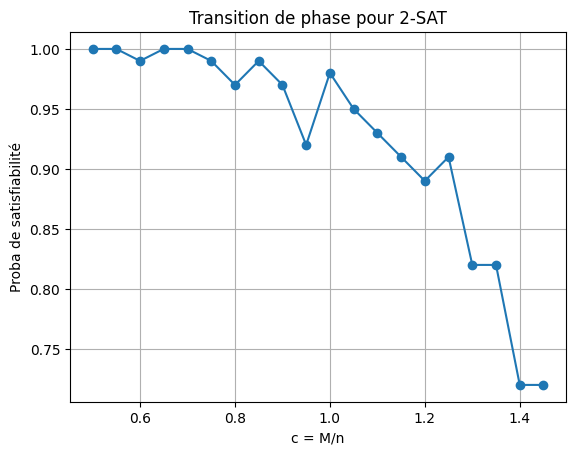

In [86]:
# Illustration de la transition de phase en c = 1
from tqdm import tqdm
n = 20
eps = 1e-2
T = compute_T(n, eps)
cs = np.arange(0.5, 1.5, 0.05)
nb_tests = 100
probas = []

for c in tqdm(cs):
    M = int(c * n)
    count_sat = 0
    for _ in range(nb_tests):
        F = TirerFormule(2, n, M)
        affectation = solv_WalkSat(F, T, n)
        if affectation is not None:
            count_sat += 1
    probas.append(count_sat / nb_tests)

plt.plot(cs, probas, marker='o')
plt.xlabel("c = M/n")
plt.ylabel("Proba de satisfiabilité")
plt.title("Transition de phase pour 2-SAT")
plt.grid(True)
plt.show()


<div markdown=1 class="Answers">